In [1]:
# Training-focused imports for pre-processed data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_theme(style="whitegrid")


In [2]:
import os
os.listdir("/kaggle/input")

os.listdir("/kaggle/input/urbanflow")

path = "/kaggle/input/urbanflow/merged_dataset_20250720_170853.csv"

df = pd.read_csv(path)

df.head()


,start_station_id,date,hour,demand_count,datetime_hour,ride_distance_km,ride_duration,is_weekend,is_peak_hour,temperature_2m,...,weather_severity,is_good_biking_weather,has_precipitation,is_comfortable_temp,is_windy,season,traffic_mean,traffic_max,traffic_sum,traffic_count
0,2733.03,2023-01-06,8,1,2023-01-06 08:00:00,1.793862,9.834400,0.0,1.0,5.8225,...,7.382609,0.0,1.0,0.0,0.0,Winter,256.50,256.50,256.50,1.0
1,2733.03,2023-01-06,15,1,2023-01-06 15:00:00,1.178464,7.245450,0.0,0.0,6.3725,...,4.409914,0.0,1.0,0.0,0.0,Winter,222.25,222.25,222.25,1.0
2,2733.03,2023-01-06,18,2,2023-01-06 18:00:00,1.686254,61.685567,0.0,1.0,7.1725,...,8.362780,0.0,1.0,0.0,0.0,Winter,169.75,169.75,169.75,1.0
3,2733.03,2023-01-06,21,1,2023-01-06 21:00:00,5.233720,15.836367,0.0,0.0,7.8725,...,4.917823,0.0,0.0,0.0,0.0,Winter,137.50,137.50,137.50,1.0
4,2733.03,2023-01-08,8,1,2023-01-08 08:00:00,1.793862,8.985350,1.0,1.0,0.0225,...,5.358493,0.0,0.0,0.0,0.0,Winter,107.25,107.25,107.25,1.0


In [3]:
df.shape

(6298240, 22)

In [4]:
# Data Preparation - Full Dataset (no filtering)

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def prepare_training_data(df, target_col=None, test_size=0.2):
    """
    Prepare clean data for model training (assumes data is already preprocessed)
    """
    print("🔄 Preparing clean data for model training...")
    
    # Work with full dataset
    print(f"📊 Working with full dataset: {len(df):,} samples")
    
    # Auto-detect target column if not specified
    if target_col is None:
        target_candidates = [col for col in df.columns if any(keyword in col.lower() for keyword in ['demand', 'count', 'target', 'y', 'label'])]
        if target_candidates:
            target_col = target_candidates[0]
            print(f"🎯 Auto-detected target column: {target_col}")
        else:
            print("❌ No target column specified and none auto-detected")
            print(f"Available columns: {list(df.columns)}")
            return None
    
    # Validate target column exists
    if target_col not in df.columns:
        print(f"❌ Target column '{target_col}' not found")
        print(f"Available columns: {list(df.columns)}")
        return None
    
    # Separate features and target
    feature_cols = [col for col in df.columns if col != target_col]
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Basic validation
    print(f"\n📊 Dataset Summary:")
    print(f"   Features: {len(feature_cols)}")
    print(f"   Samples: {len(df):,}")
    print(f"   Target: {target_col}")
    print(f"   Target range: {y.min():.1f} - {y.max():.1f}")
    print(f"   Target mean: {y.mean():.1f} ± {y.std():.1f}")
    
    # Check for missing values
    missing_features = X.isnull().sum().sum()
    missing_target = y.isnull().sum()
    
    if missing_features > 0:
        print(f"⚠️ Found {missing_features} missing values in features")
    if missing_target > 0:
        print(f"⚠️ Found {missing_target} missing values in target")
    
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, shuffle=True
    )
    
    print(f"\n✅ Training data prepared:")
    print(f"   🏋️ Training samples: {X_train.shape[0]:,}")
    print(f"   🧪 Test samples: {X_test.shape[0]:,}")
    
    # Show feature summary
    print(f"\n📋 Features ({len(X.columns)}):")
    for i, col in enumerate(X.columns):
        if i < 10:  # Show first 10
            dtype = str(X[col].dtype)
            nulls = X[col].isnull().sum()
            print(f"   {i+1:2d}. {col:<25} ({dtype}, {nulls} nulls)")
        elif i == 10:
            print(f"   ... and {len(X.columns)-10} more features")
            break
    
    return X_train, X_test, y_train, y_test, list(X.columns)


# Prepare the data with full dataset
if 'df' in locals() and df is not None:
    print("🚀 Starting data preparation with full dataset...")
    training_data = prepare_training_data(df)
    
    if training_data is not None:
        X_train, X_test, y_train, y_test, feature_names = training_data
        print(f"\n🚀 Ready for FULL model training!")
    else:
        print("❌ Data preparation failed - please check your dataset")
else:
    print("❌ No dataset loaded. Please run the data loading cell first.")


🚀 Starting data preparation with full dataset...
🔄 Preparing clean data for model training...
📊 Working with full dataset: 6,298,240 samples
🎯 Auto-detected target column: demand_count

📊 Dataset Summary:
   Features: 21
   Samples: 6,298,240
   Target: demand_count
   Target range: 1.0 - 146.0
   Target mean: 3.4 ± 4.0

✅ Training data prepared:
   🏋️ Training samples: 5,038,592
   🧪 Test samples: 1,259,648

📋 Features (21):
    1. start_station_id          (object, 0 nulls)
    2. date                      (object, 0 nulls)
    3. hour                      (int64, 0 nulls)
    4. datetime_hour             (object, 0 nulls)
    5. ride_distance_km          (float64, 0 nulls)
    6. ride_duration             (float64, 0 nulls)
    7. is_weekend                (float64, 0 nulls)
    8. is_peak_hour              (float64, 0 nulls)
    9. temperature_2m            (float64, 0 nulls)
   10. precipitation             (float64, 0 nulls)
   ... and 11 more features

🚀 Ready for FULL model tra

In [5]:
# 📌 Remove non-numeric columns from training and test features
non_numeric_cols = ['start_station_id', 'date', 'datetime_hour', 'season']

X_train = X_train.drop(columns=non_numeric_cols, errors='ignore')
X_test = X_test.drop(columns=non_numeric_cols, errors='ignore')

print("✅ Dropped non-numeric columns:", non_numeric_cols)
print("📊 New shapes -> X_train:", X_train.shape, ", X_test:", X_test.shape)


✅ Dropped non-numeric columns: ['start_station_id', 'date', 'datetime_hour', 'season']
📊 New shapes -> X_train: (5038592, 17) , X_test: (1259648, 17)


In [6]:
# Data Validation and Setup for Model Training
def validate_training_data(X_train, X_test, y_train, y_test):
    """
    Validate input data before training models
    """
    print("🔍 Validating input data...")
    
    # Check for non-numeric data
    if not all(X_train.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        print("❌ Non-numeric data detected in features!")
        print("   Non-numeric columns:", X_train.select_dtypes(exclude=[np.number]).columns.tolist())
        return False
    
    # Check for missing values
    if X_train.isnull().any().any():
        print("❌ Missing values detected in training features!")
        return False
    
    if X_test.isnull().any().any():
        print("❌ Missing values detected in test features!")
        return False
    
    # Check for infinite values
    if np.isinf(X_train.values).any():
        print("❌ Infinite values detected in training features!")
        return False
    
    print("✅ Data validation passed")
    return True

def detect_task_type(y_train):
    """
    Auto-detect whether this is a classification or regression task
    """
    unique_values = len(np.unique(y_train))
    if unique_values <= 20 and y_train.dtype in ['int64', 'int32', 'object', 'category']:
        task_type = 'classification'
        print("🔍 Auto-detected: Classification task")
    else:
        task_type = 'regression'
        print("🔍 Auto-detected: Regression task")
    
    return task_type

# Initialize variables for model results
if 'X_train' in locals() and X_train is not None:
    # Validate data
    data_valid = validate_training_data(X_train, X_test, y_train, y_test)
    
    if data_valid:
        # Detect task type
        task_type = detect_task_type(y_train)
        
        # Initialize results storage
        model_results_list = []
        trained_models_dict = {}
        
        print(f"\n🎯 Preparing for {task_type} training...")
        print(f"📊 Training set: {X_train.shape}, Test set: {X_test.shape}")
        print("⚡ Models will be trained in separate cells for better control")
        
        # Set scoring metric
        if task_type == 'regression':
            scoring_metric = 'neg_root_mean_squared_error'
            print("📈 Scoring metric: RMSE")
        else:
            scoring_metric = 'f1_weighted'
            print("📈 Scoring metric: F1-weighted")
    else:
        print("❌ Data validation failed. Please fix data issues before training.")
else:
    print("❌ Training data not prepared. Please run the data preparation cell first.")

🔍 Validating input data...
✅ Data validation passed
🔍 Auto-detected: Regression task

🎯 Preparing for regression training...
📊 Training set: (5038592, 17), Test set: (1259648, 17)
⚡ Models will be trained in separate cells for better control
📈 Scoring metric: RMSE


In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import randint
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score

if 'data_valid' in locals() and data_valid:
    print("🏋️ Training Random Forest with subset tuning...")

    try:
        # 1️⃣ Sample a subset for hyperparameter tuning
        subset_size = 100000  # adjust based on your RAM
        X_sub = X_train.sample(n=subset_size, random_state=42)
        y_sub = y_train.loc[X_sub.index]
        print(f"   📊 Using subset of {subset_size} rows for tuning")

        # 2️⃣ Define base model
        if task_type == 'regression':
            base_model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=50, max_depth=8)
            model_name = 'Random Forest'
            scoring_metric = 'neg_root_mean_squared_error'
        else:
            base_model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=50, max_depth=8)
            model_name = 'Random Forest'
            scoring_metric = 'f1_weighted'

        # 3️⃣ Hyperparameter search
        param_grid = {
            'n_estimators': randint(50, 150),
            'max_depth': randint(5, 15),
            'min_samples_split': randint(2, 10)
        }

        search = RandomizedSearchCV(
            base_model,
            param_distributions=param_grid,
            n_iter=5,  # quick tuning
            cv=3,
            scoring=scoring_metric,
            random_state=42,
            n_jobs=-1,
            error_score='raise'
        )

        search.fit(X_sub, y_sub)
        best_params = search.best_params_
        print(f"   🎛️ Best params from subset tuning: {best_params}")

        # 4️⃣ Retrain on full dataset with best params and more trees
        if task_type == 'regression':
            model = RandomForestRegressor(
                random_state=42,
                n_jobs=-1,
                **best_params
            )
        else:
            model = RandomForestClassifier(
                n_estimators=300,
                random_state=42,
                n_jobs=-1,
                **best_params
            )

        print("   🏋️ Retraining on full dataset...")
        model.fit(X_train, y_train)

        # 5️⃣ Make predictions
        y_pred = model.predict(X_test)

        # 6️⃣ Evaluate
        if task_type == 'regression':
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            result = {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R²': r2}
            print(f"   📊 RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
        else:
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            result = {'Model': model_name, 'Accuracy': accuracy, 'F1_Score': f1}
            print(f"   📊 Accuracy: {accuracy:.3f}, F1: {f1:.3f}")

        # 7️⃣ Store results
        model_results_list.append(result)
        trained_models_dict[model_name] = model
        print(f"   ✅ {model_name} training completed successfully!")

    except Exception as e:
        print(f"   ❌ {model_name} failed: {str(e)[:100]}...")

else:
    print("❌ Data validation failed. Cannot train Random Forest.")


🏋️ Training Random Forest with subset tuning...
   📊 Using subset of 100000 rows for tuning
   🎛️ Best params from subset tuning: {'max_depth': 12, 'min_samples_split': 6, 'n_estimators': 149}
   🏋️ Retraining on full dataset...
   📊 RMSE: 3.53, MAE: 2.08, R²: 0.237
   ✅ Random Forest training completed successfully!


In [8]:
import joblib
import os

os.makedirs("models", exist_ok=True)  # create folder in Kaggle environment
joblib.dump(model, "models/random_forest.pkl")


['models/random_forest.pkl']

📊 Comparing Model Performance...
✅ Successfully trained 2 models

📋 Results Summary:


,Model,RMSE,MAE,R²
0,Random Forest,3.532510,2.077472,0.237346
1,Linear Regression,3.969047,2.509779,0.037206


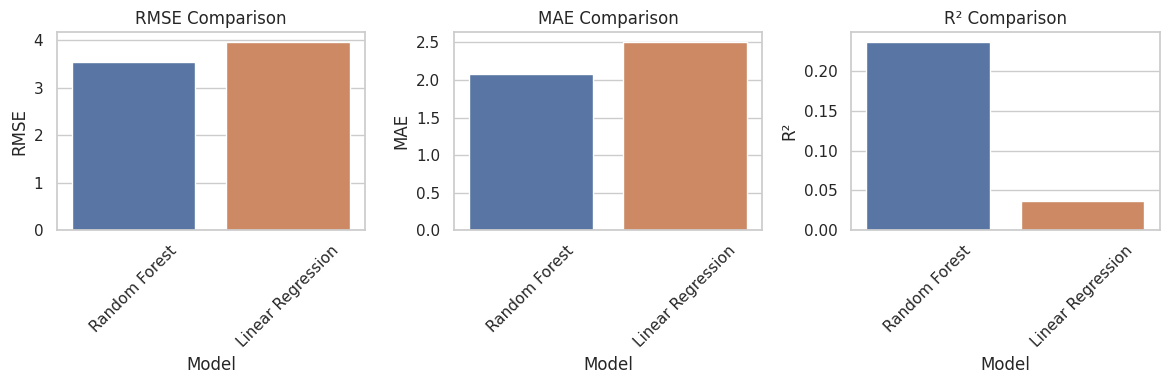


🏆 Champion Model: Random Forest
🎯 Best R²: 0.2373
⚡ Training completed successfully!


In [10]:
# Model Results Comparison and Champion Selection
if 'model_results_list' in locals() and len(model_results_list) > 0:
    print("📊 Comparing Model Performance...")
    
    # Create results dataframe
    model_results = pd.DataFrame(model_results_list)
    
    print(f"✅ Successfully trained {len(model_results)} models")
    print("\n📋 Results Summary:")
    display(model_results)
    
    # Visualization
    try:
        if task_type == 'regression':
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            metrics = ['RMSE', 'MAE', 'R²']
        else:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            metrics = ['Accuracy', 'F1_Score']
        
        for i, metric in enumerate(metrics):
            if metric in model_results.columns:
                sns.barplot(data=model_results, x='Model', y=metric, ax=axes[i])
                axes[i].set_title(f'{metric} Comparison')
                axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Visualization failed: {str(e)}")
    
    # Select champion model
    if task_type == 'regression':
        best_idx = model_results['R²'].idxmax()
        best_metric = 'R²'
        best_score = model_results.loc[best_idx, 'R²']
    else:
        best_idx = model_results['F1_Score'].idxmax()
        best_metric = 'F1_Score'
        best_score = model_results.loc[best_idx, 'F1_Score']
    
    champion_model_name = model_results.loc[best_idx, 'Model']
    champion_model = trained_models_dict[champion_model_name]
    
    print(f"\n🏆 Champion Model: {champion_model_name}")
    print(f"🎯 Best {best_metric}: {best_score:.4f}")
    print(f"⚡ Training completed successfully!")
    
    # Store for analysis
    trained_models = trained_models_dict
    
else:
    print("❌ No models were successfully trained.")
    print("💡 Please run the individual model training cells above.")

🔬 Starting detailed analysis of champion model...
🔬 CHAMPION MODEL ANALYSIS: Random Forest

🎯 FEATURE IMPORTANCE ANALYSIS:

📊 TOP 15 MOST IMPORTANT FEATURES:
   ride_distance_km          0.3314
   ride_duration             0.3020
   hour                      0.1255
   is_peak_hour              0.0921
   is_weekend                0.0335
   traffic_sum               0.0313
   temperature_2m            0.0243
   weather_severity          0.0216
   traffic_mean              0.0143
   traffic_max               0.0136
   traffic_count             0.0056
   precipitation             0.0025
   wind_speed_10m            0.0016
   has_precipitation         0.0007
   is_good_biking_weather    0.0003


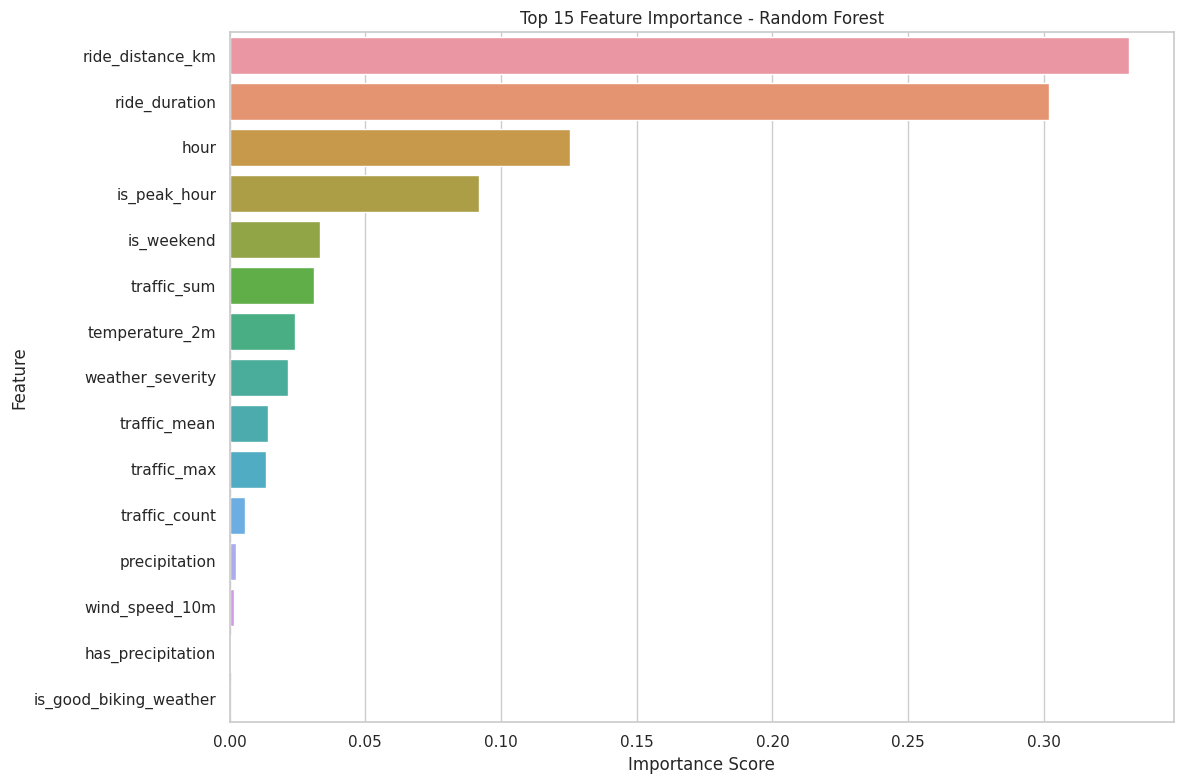


📈 FEATURE IMPORTANCE STATS:
   Total features: 17
   Features with >1% importance: 10
   Top 5 features contribute: 88.4%
   Top 10 features contribute: 98.9%

🎯 CROSS-VALIDATION PERFORMANCE:
   Mean CV RMSE: 3.528
   Std CV RMSE:  0.011
   CV Range:     3.508 - 3.538

📊 PREDICTION ANALYSIS:
   Mean Absolute Error: 2.077
   Mean Prediction: 3.405
   Mean Actual: 3.402
   Prediction Std: 1.902
   Actual Std: 4.045


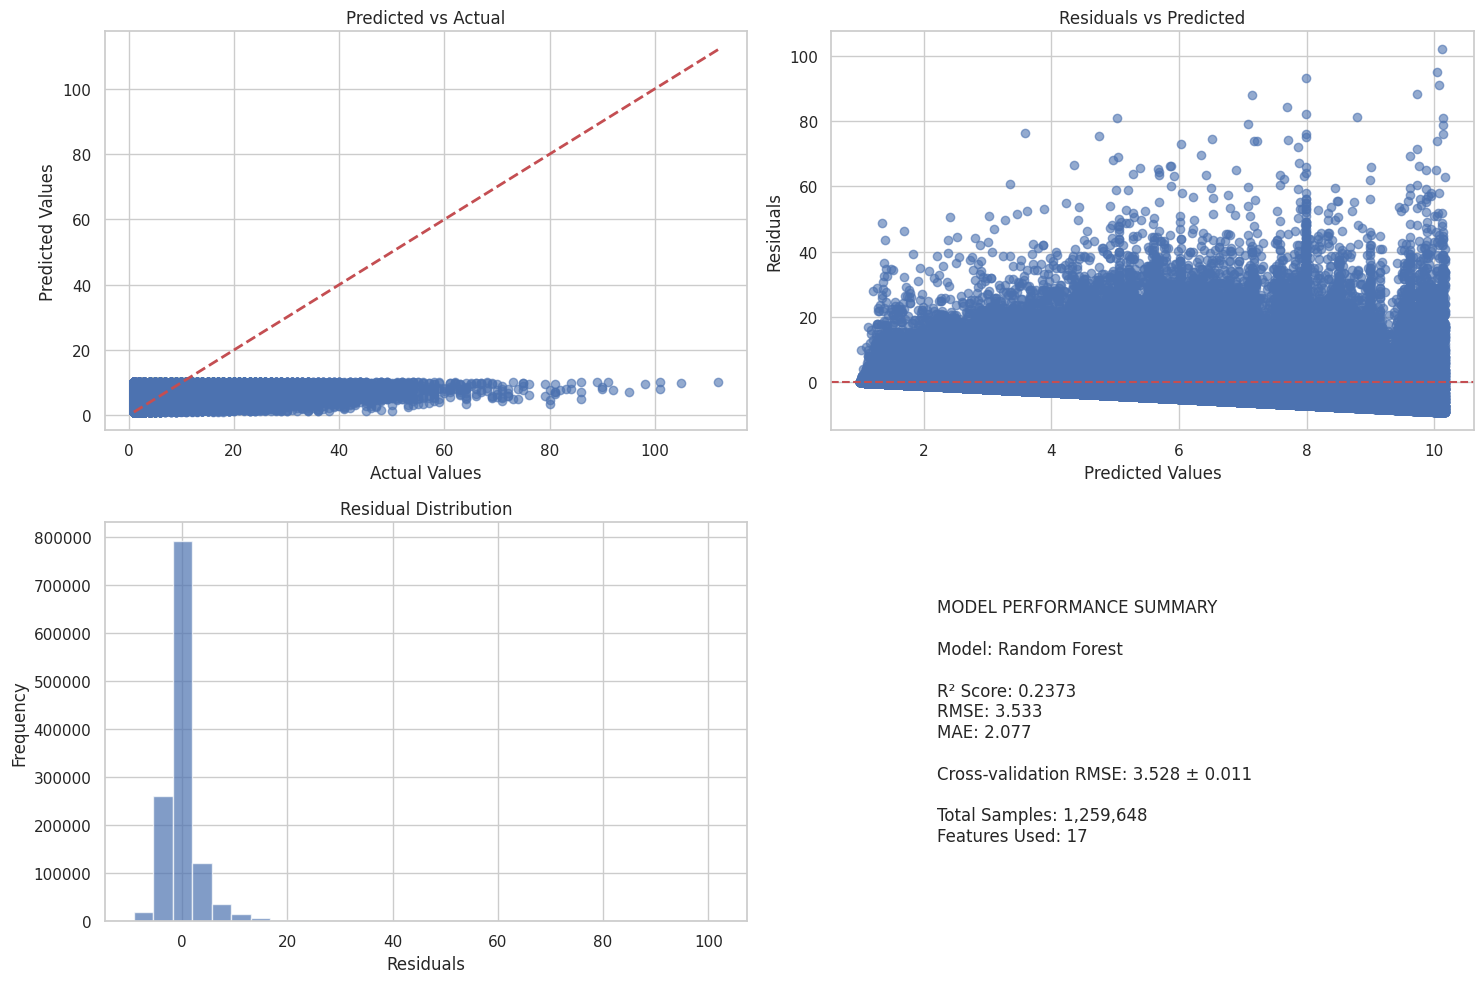


🎉 Champion model analysis completed!
🚀 Random Forest is ready for deployment


In [11]:
# ===============================
# Champion Model Analysis
# ===============================

def analyze_champion_model(model, X_test, y_test, feature_names, model_name):
    """Detailed analysis of the best performing model"""
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("="*70)
    print(f"🔬 CHAMPION MODEL ANALYSIS: {model_name}")
    print("="*70)
    
    # Ensure feature_names matches model input
    if len(feature_names) != X_test.shape[1]:
        print(f"⚠️ feature_names length ({len(feature_names)}) != X_test columns ({X_test.shape[1]}). Adjusting automatically.")
        feature_names = X_test.columns.tolist()
    
    # Feature Importance (tree-based models)
    if hasattr(model, 'feature_importances_'):
        print("\n🎯 FEATURE IMPORTANCE ANALYSIS:")
        
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Top 15 features
        top_features = feature_importance_df.head(15)
        print(f"\n📊 TOP 15 MOST IMPORTANT FEATURES:")
        for idx, row in top_features.iterrows():
            print(f"   {row['Feature']:<25} {row['Importance']:.4f}")
        
        # Visualization
        plt.figure(figsize=(12, 8))
        sns.barplot(data=top_features, x='Importance', y='Feature')
        plt.title(f'Top 15 Feature Importance - {model_name}')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Feature importance statistics
        print(f"\n📈 FEATURE IMPORTANCE STATS:")
        print(f"   Total features: {len(feature_names)}")
        print(f"   Features with >1% importance: {sum(importances > 0.01)}")
        print(f"   Top 5 features contribute: {top_features.head(5)['Importance'].sum():.1%}")
        print(f"   Top 10 features contribute: {top_features.head(10)['Importance'].sum():.1%}")
        
        return feature_importance_df
    
    else:
        print("\n📊 Linear model - no feature importance available")
        return None


def analyze_model_performance(model, X_test, y_test, model_name, task_type):
    """Analyze model performance with plots"""
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    if task_type == 'regression':
        # Cross-validation performance
        print(f"\n🎯 CROSS-VALIDATION PERFORMANCE:")
        cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_root_mean_squared_error')
        cv_scores = -cv_scores  # Convert to positive RMSE
        
        print(f"   Mean CV RMSE: {cv_scores.mean():.3f}")
        print(f"   Std CV RMSE:  {cv_scores.std():.3f}")
        print(f"   CV Range:     {cv_scores.min():.3f} - {cv_scores.max():.3f}")
        
        # Prediction analysis
        residuals = y_test - y_pred
        
        print(f"\n📊 PREDICTION ANALYSIS:")
        print(f"   Mean Absolute Error: {np.mean(np.abs(residuals)):.3f}")
        print(f"   Mean Prediction: {np.mean(y_pred):.3f}")
        print(f"   Mean Actual: {np.mean(y_test):.3f}")
        print(f"   Prediction Std: {np.std(y_pred):.3f}")
        print(f"   Actual Std: {np.std(y_test):.3f}")
        
        # Residual plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Predicted vs Actual
        axes[0,0].scatter(y_test, y_pred, alpha=0.6)
        axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0,0].set_xlabel('Actual Values')
        axes[0,0].set_ylabel('Predicted Values')
        axes[0,0].set_title('Predicted vs Actual')
        
        # Residuals vs Predicted
        axes[0,1].scatter(y_pred, residuals, alpha=0.6)
        axes[0,1].axhline(y=0, color='r', linestyle='--')
        axes[0,1].set_xlabel('Predicted Values')
        axes[0,1].set_ylabel('Residuals')
        axes[0,1].set_title('Residuals vs Predicted')
        
        # Residual distribution
        axes[1,0].hist(residuals, bins=30, alpha=0.7)
        axes[1,0].set_xlabel('Residuals')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Residual Distribution')
        
        # Model performance summary
        axes[1,1].axis('off')
        performance_text = f"""
        MODEL PERFORMANCE SUMMARY
        
        Model: {model_name}
        
        R² Score: {r2_score(y_test, y_pred):.4f}
        RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}
        MAE: {mean_absolute_error(y_test, y_pred):.3f}
        
        Cross-validation RMSE: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}
        
        Total Samples: {len(y_test):,}
        Features Used: {X_test.shape[1]}
        """
        axes[1,1].text(0.1, 0.5, performance_text, fontsize=12, verticalalignment='center')
        
        plt.tight_layout()
        plt.show()
    
    else:  # Classification
        from sklearn.metrics import classification_report
        print(f"\n📊 CLASSIFICATION REPORT:")
        print(classification_report(y_test, y_pred))


# ===============================
# Run Champion Model Analysis
# ===============================

if 'champion_model' in locals() and 'champion_model_name' in locals():
    print("🔬 Starting detailed analysis of champion model...")
    
    # Make sure feature names match the model input
    feature_names = X_train.columns.tolist()
    
    # Feature importance analysis
    feature_analysis = analyze_champion_model(
        champion_model, X_test, y_test, feature_names, champion_model_name
    )
    
    # Performance analysis
    analyze_model_performance(
        champion_model, X_test, y_test, champion_model_name, task_type
    )
    
    print(f"\n🎉 Champion model analysis completed!")
    print(f"🚀 {champion_model_name} is ready for deployment")
    
else:
    print("❌ No champion model available.")
    print("💡 Please run the model training and comparison cells first.")
